In [1]:
%load_ext autoreload
%autoreload 2

from math import sqrt, log
import os
import re

import jax
from jax import random
import jax.numpy as jnp
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar

from diffbank.bank import Bank
from diffbank.noise import Sn_aLIGO
from diffbank.utils import (
    get_m1_m2_sampler,
    gen_template_rejection,
    gen_templates_rejection,
)
from diffbank.waveforms.threePN_simple import Psi, amp

key = random.PRNGKey(1834)

In [2]:
# mm -> (p_est, p_est_err), from threePN-p.txt
ps = {
    0.95: (0.0022500000000000003, 0.0003350326476628807),
    0.9: (0.004, 0.000446318272088428),
    0.85: (0.00585, 0.0005392484353245727),
    0.8: (0.01025, 0.000712212661358951),
    0.75: (0.01, 0.0007035623639735144),
}

## Bank generation time

In [3]:
runtimes = {}
filenames = os.listdir("../scripts/threePN-outputs-scaling/")

for fn in filenames:
    kind = fn.split("-")[1]
    mm = float(re.search("mm=(\d*\.\d*)-", fn).group(1))
    eta_star = float(re.search("eta_star=(\d*\.\d*)\.txt", fn).group(1))

    with open(os.path.join("../scripts/threePN-outputs-scaling", fn)) as f:
        raw = f.read()
        last_pbar = raw.split("\n")[-4]
    
        # Convert to runtime [s]
        search_result = re.search("\[(.*)<", last_pbar)
        if search_result is not None:
            raw_time = search_result.group(1)
        else:
            raw_time = re.search("\[(.*?),", last_pbar).group(1)
        raw_time = raw_time.split(":")
        assert len(raw_time) <= 3
        time = sum([float(rt) * 60 ** i for i, rt in enumerate(reversed(raw_time))])

    runtimes[(kind, mm, eta_star)] = time

In [4]:
def cs_cr_pred(p, eta_star, n_eff=1000):
    return 1 / (n_eff * p) * (1 + jnp.log(1 - eta_star)) / (eta_star - 1)


def cs_cr_pred_err(p_err, p, eta_star, n_eff=1000):
    return cs_cr_pred(p, eta_star) / p * p_err

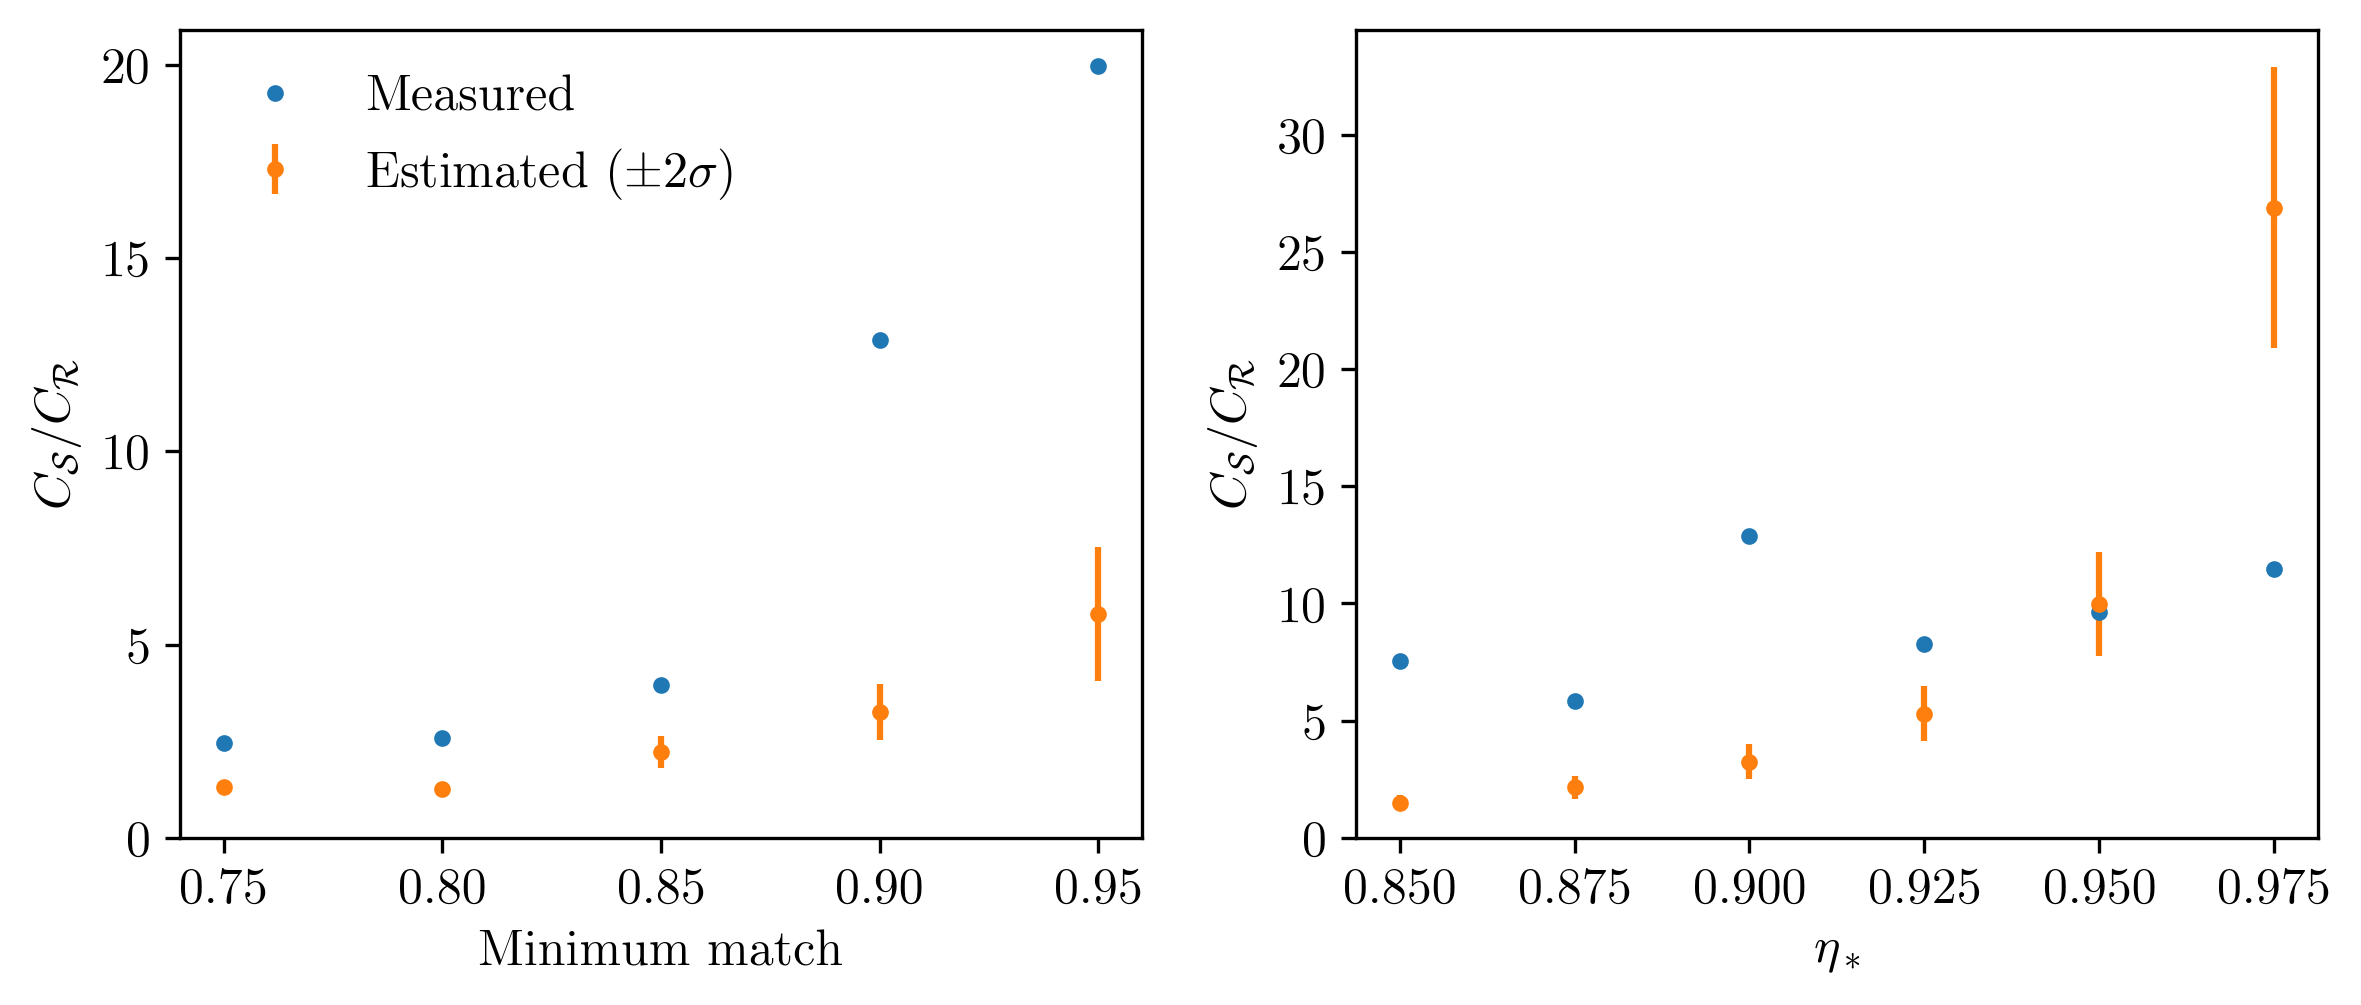

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3.5))

# mm scaling
eta_star_ref = 0.9
mms = jnp.array([0.75, 0.80, 0.85, 0.90, 0.95])
p_ests = jnp.array([ps[mm][0] for mm in mms])
p_errs = jnp.array([ps[mm][1] for mm in mms])
# eta_star scaling
eta_stars = jnp.array([0.850, 0.875, 0.900, 0.925, 0.950, 0.975])
mm_ref = 0.9
p_est_ref = ps[mm_ref][0]
p_err_ref = ps[mm_ref][1]

ax = axs[0]
c_ss = jnp.array([runtimes[("stochastic", mm, eta_star_ref)] for mm in mms])
c_rs = jnp.array([runtimes[("random", mm, eta_star_ref)] for mm in mms])
ax.plot(mms, c_ss / c_rs, ".", label="Measured")
ax.errorbar(
    mms,
    cs_cr_pred(p_ests, eta_star_ref),
    2 * cs_cr_pred_err(p_errs, p_ests, eta_star_ref),
    label=f"Estimated ($\pm 2\sigma$)",
    fmt="."
)
ax.set_xlabel("Minimum match")
ax.set_ylabel(r"$C_\mathcal{S} / C_\mathcal{R}$")
ax.set_ylim(0, None)
ax.legend(loc="upper left", frameon=False)

ax = axs[1]
c_ss = jnp.array([runtimes[("stochastic", mm_ref, eta_star)] for eta_star in eta_stars])
c_rs = jnp.array([runtimes[("random", mm_ref, eta_star)] for eta_star in eta_stars])
ax.plot(eta_stars, c_ss / c_rs, ".", label="Measured")
ax.errorbar(
    eta_stars,
    cs_cr_pred(p_est_ref, eta_stars),
    2 * cs_cr_pred_err(p_err_ref, p_est_ref, eta_stars),
    label=f"Estimated ($\pm 2\sigma$)",
    fmt="."
)
ax.set_xlabel(r"$\eta_*$")
ax.set_ylabel(r"$C_\mathcal{S} / C_\mathcal{R}$")
ax.set_ylim(0, None)

fig.tight_layout()

## Number of templates

In [28]:
fs = jnp.linspace(20.0, 2000.0, 1000)
m_range = (1.4, 5.0)
sampler = get_m1_m2_sampler(m_range, m_range)
ns, n_ests, n_est_errs = {}, {}, {}

# Varying mm
eta_star_ref = 0.9
mms = [0.95, 0.90, 0.85, 0.80, 0.75]
for seed, mm in enumerate(mms, 5):
    path = os.path.join(
        "../scripts/threePN-banks-scaling",
        f"3pn-random-{seed}-mm={mm}-eta_star={eta_star_ref}-n_eff=1000.npz",
    )
    # Measurement
    ns[(mm, eta_star_ref)] = Bank.load(path, amp, Psi, Sn_aLIGO, sampler).n_templates
    # Prediction
    p, p_err = ps[mm]
    n_ests[(mm, eta_star_ref)] = log(1 - eta_star) / log(1 - p)
    n_est_errs[(mm, eta_star_ref)] = (
        log(1 - eta_star) / ((1 - p) * log(1 - p) ** 2) * p_err
    )

# Varying eta_star
mm_ref = 0.9
eta_stars = [0.975, 0.95, 0.925, 0.900, 0.875, 0.850]
for seed, eta_star in enumerate(eta_stars, 15):
    path = os.path.join(
        "../scripts/threePN-banks-scaling",
        f"3pn-random-{seed}-mm={mm_ref}-eta_star={eta_star}-n_eff=1000.npz",
    )
    # Measurement
    ns[(mm_ref, eta_star)] = Bank.load(path, amp, Psi, Sn_aLIGO, sampler).n_templates
    # Prediction
    p, p_err = ps[mm_ref]
    n_ests[(mm_ref, eta_star)] = log(1 - eta_star) / log(1 - p)
    n_est_errs[(mm_ref, eta_star)] = (
        log(1 - eta_star) / ((1 - p) * log(1 - p) ** 2) * p_err
    )

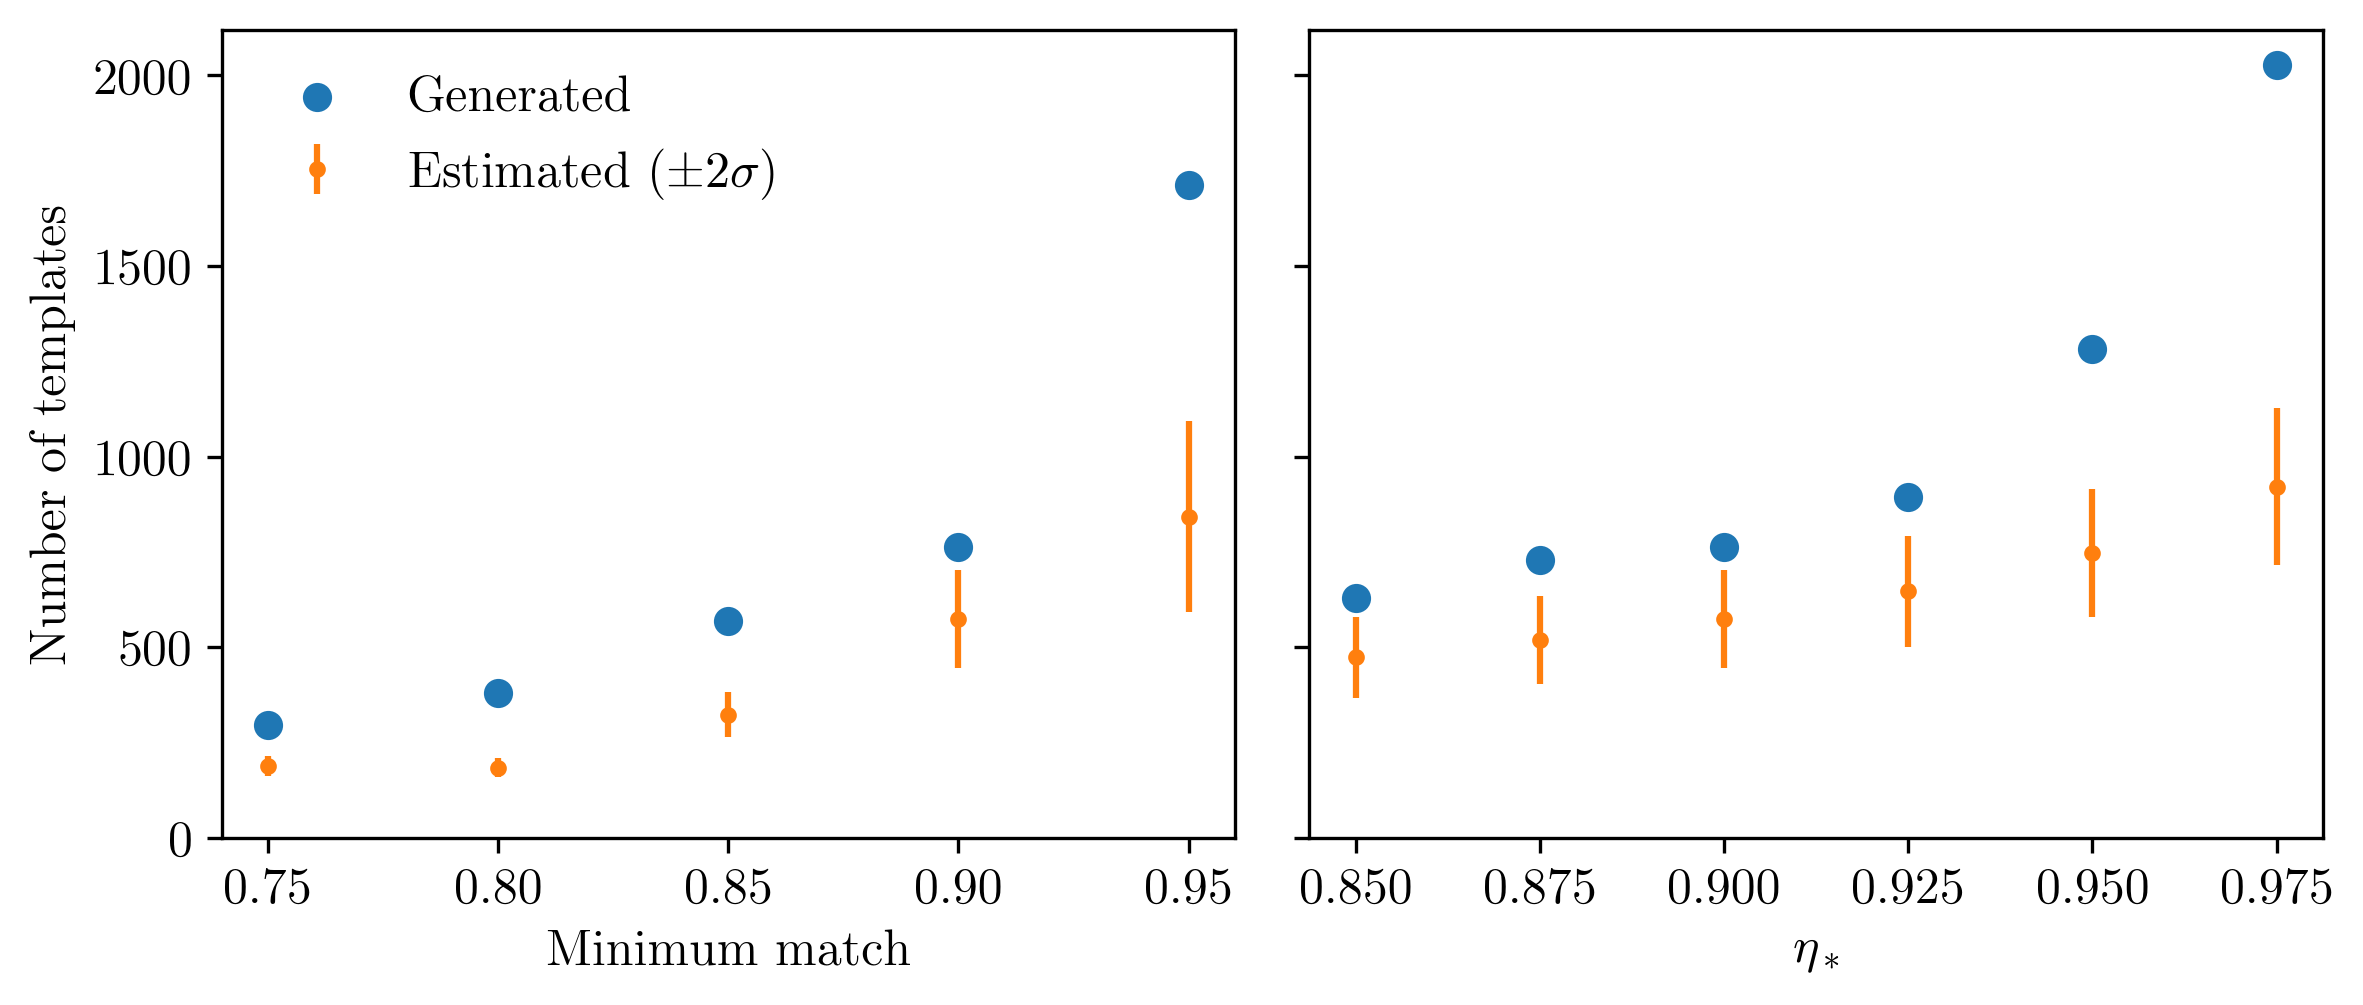

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3.5), sharey=True)

ax = axs[0]
ax.scatter(mms, [ns[(mm, eta_star_ref)] for mm in mms], c="C0", label="Generated")
ax.errorbar(
    mms,
    [n_ests[(mm, eta_star_ref)] for mm in mms],
    2 * jnp.array([n_est_errs[(mm, eta_star_ref)] for mm in mms]),
    fmt=".",
    c="C1",
    label=f"Estimated ($\pm 2\sigma$)",
)
ax.set_xlabel("Minimum match")
ax.set_ylabel("Number of templates")
ax.legend(loc="upper left", frameon=False)

ax = axs[1]
ax.scatter(eta_stars, [ns[(mm_ref, eta_star)] for eta_star in eta_stars], c="C0", label="Generated")
ax.errorbar(
    eta_stars,
    [n_ests[(mm_ref, eta_star)] for eta_star in eta_stars],
    2 * jnp.array([n_est_errs[(mm_ref, eta_star)] for eta_star in eta_stars]),
    fmt=".",
    c="C1",
    label=f"Estimated ($\pm 2\sigma$)",
)
ax.set_xlabel(r"$\eta_*$")
ax.set_ylim(0, None)

fig.tight_layout()

## Dev

Estimate $p$, the probability a given point is covered by a template

In [23]:
seed = 0
kind = "random"
n_eta = 0
mm = 0.9
eta_star = 0.9
n_eff = 1000
suffix = f"eta={eta_star}-mm={mm}-neff={n_eff}"

In [24]:
key = random.PRNGKey(seed)
m_star = 1 - mm

fs = jnp.linspace(20.0, 2000.0, 1000)
m_range = (1.4, 5.0)
sampler = get_m1_m2_sampler(m_range, m_range)

bank = Bank(
    amp,
    Psi,
    fs,
    Sn_aLIGO,
    m_star,
    eta_star,
    sampler,
    name=f"3pn-{seed}-test",
)

# Get max density
fun = lambda m1: -bank.density_fun(jnp.array([m1, m_range[0]]))
res = minimize_scalar(fun, bracket=m_range, bounds=m_range)
assert res.success
theta_dmax = jnp.array([res.x, m_range[0]])
ratio_max = bank.density_fun(theta_dmax)
bank.ratio_max = ratio_max

In [25]:
n_templates = 10000
gen_templates = jax.jit(
    lambda key: gen_templates_rejection(
        key,
        n_templates,
        bank.ratio_max,
        bank.density_fun,
        bank.sample_base,
        bank.density_fun_base,
    )
)

In [26]:
key, template_key, eff_pt_key = random.split(key, 3)
templates = gen_templates(template_key)
eff_pts = gen_templates(eff_pt_key)

In [27]:
matches = jax.lax.map(
    jax.jit(lambda tep: bank.effectualness_fun(tep["t"], tep["ep"])),
    {"t": templates, "ep": eff_pts},
)
covereds = matches > mm

In [28]:
p, p_err = covereds.mean(), covereds.std() / sqrt(len(covereds))

In [29]:
p, p_err

(DeviceArray(0.0038, dtype=float64), DeviceArray(0.00061527, dtype=float64))

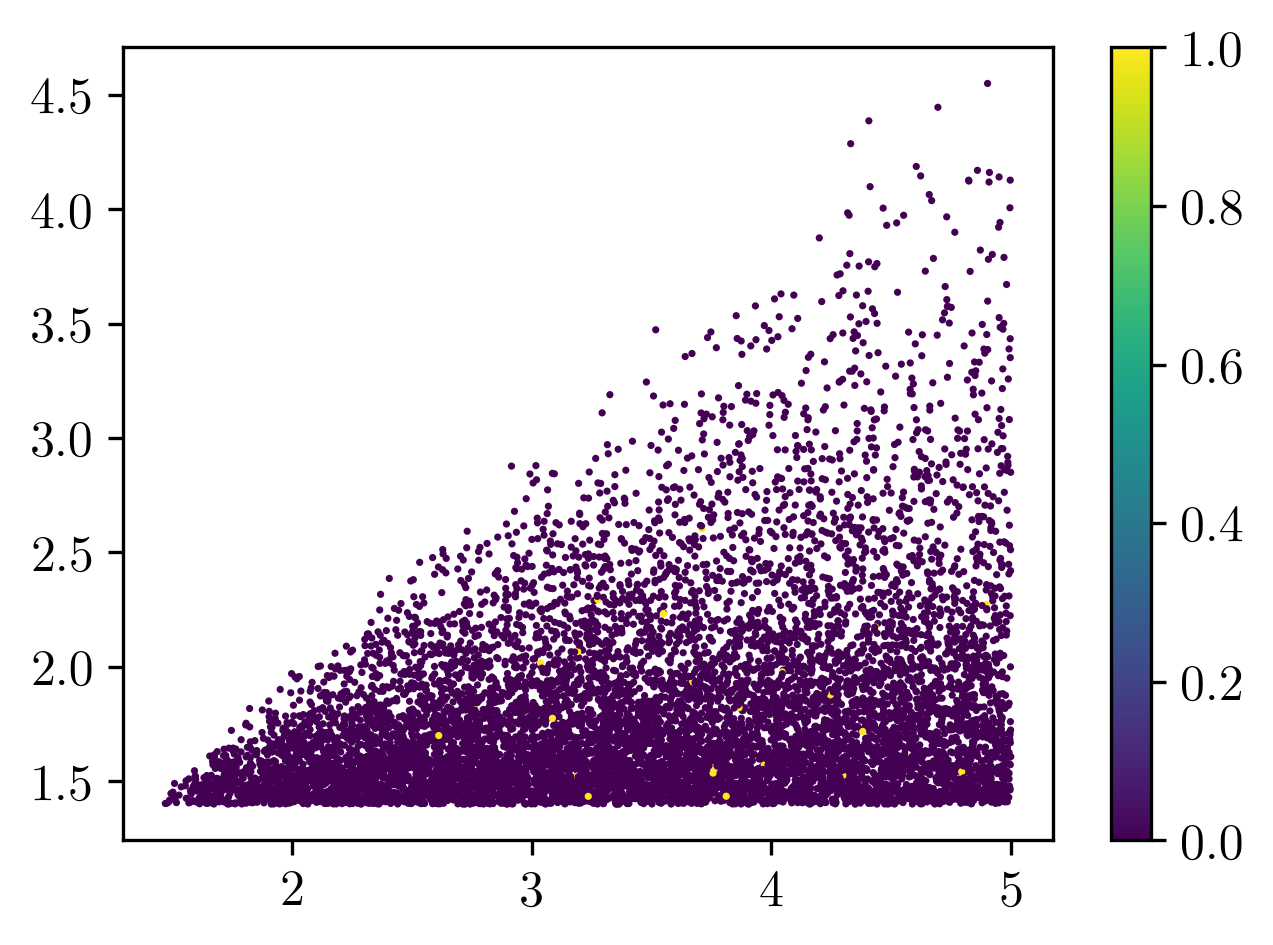

In [37]:
plt.scatter(*eff_pts.T, c=matches > mm, s=3, lw=0)
plt.colorbar()